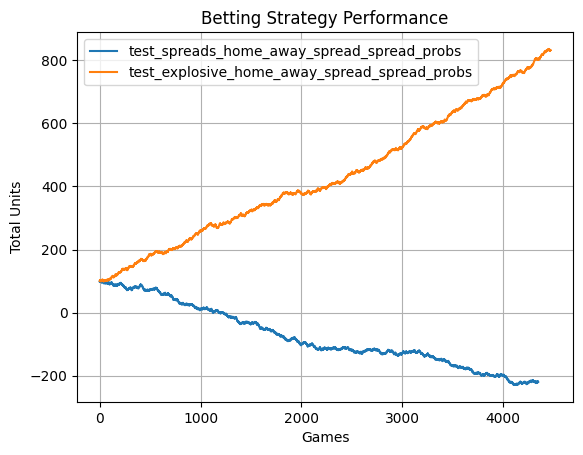

,Mean Average Error,Mean Squared Error,R-Squared,Sharpe,Net PNL,Max Drawdown,Number of Bets,Winning Bet %
model,,,,,,,,
test_spreads_home_away_spread_spread_probs,15.669494,395.843780,0.338447,-3.318814,-319.15,-329.12,4349,0.495516
test_explosive_home_away_spread_spread_probs,14.829107,359.956654,0.398423,3.599680,732.21,-0.91,4472,0.622317
book,12.341968,245.126155,0.503595,0.000000,0.00,0.00,0,0.000000


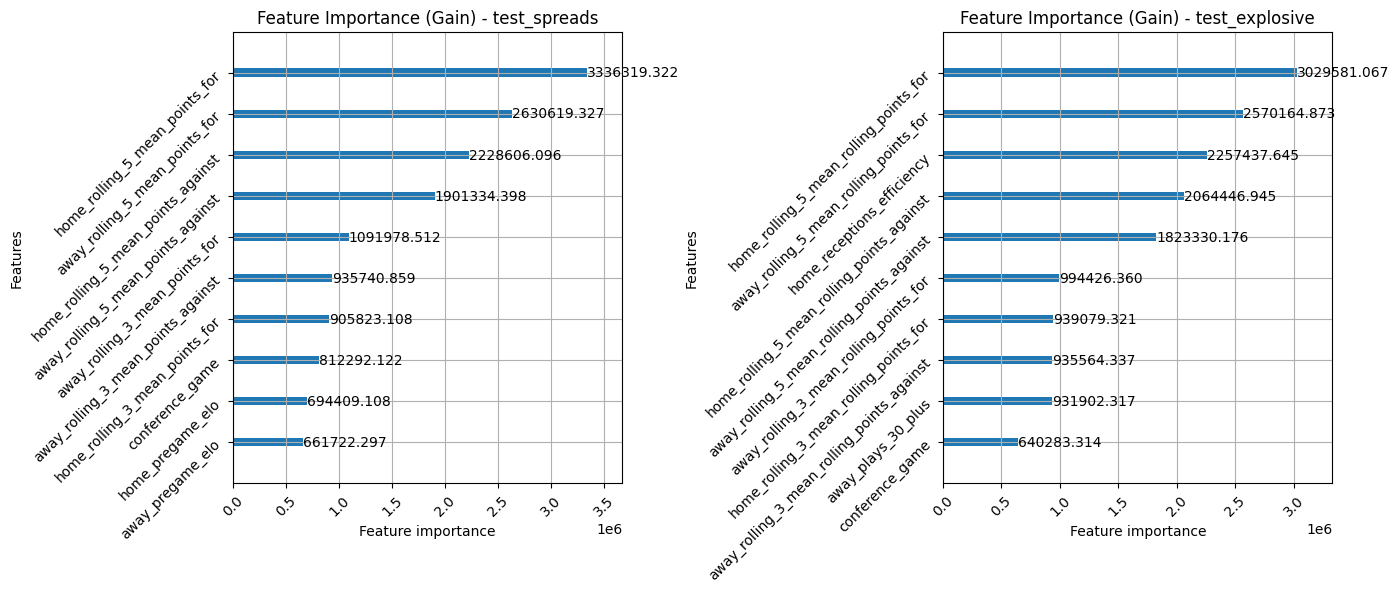

In [6]:
from evaluation import compare_models
compare_models("test_spreads", "test_explosive", "home_away_spread", ("spread_probs", "spread_probs"))

In [ ]:
from evaluation import get_model_interpretability

In [ ]:
get_model_interpretability("test_spreads", "home_away_spread")

,home_offense_total,home_defense_total,home_pass_game_total,home_run_game_total,away_offense_total,away_defense_total,away_pass_game_total,away_run_game_total,home_classification_fbs,home_classification_fcs,...,away_rolling_1_mean_passing_yds_given_up,home_rolling_3_mean_passing_yds_given_up,away_rolling_3_mean_passing_yds_given_up,home_rolling_5_mean_passing_yds_given_up,away_rolling_5_mean_passing_yds_given_up,home_kalman_points_against,away_kalman_points_against,bias,season_type_spring_postseason,season_type_spring_regular
id,,,,,,,,,,,,,,,,,,,,,
401012246,0.837298,-0.141287,0.0,0.0,-0.139066,-0.128649,0.0,0.0,-0.215182,0.087393,...,-0.076533,-0.073255,-0.006277,-0.100708,-0.278759,-0.141287,-0.128649,-6.548922,NaN,NaN
401012247,0.764494,-0.257952,0.0,0.0,-0.207880,-0.147167,0.0,0.0,-0.805581,0.169445,...,-0.088335,-0.084625,-0.020602,-0.084482,-0.391405,-0.257952,-0.147167,-6.548922,NaN,NaN
401012248,0.815614,-0.351773,0.0,0.0,-0.288964,-0.122904,0.0,0.0,-0.215182,0.087393,...,-0.298307,-0.031022,-0.025908,-0.092620,-0.225909,-0.351773,-0.122904,-6.548922,NaN,NaN
401012249,0.783439,-0.243663,0.0,0.0,-0.149951,-0.156719,0.0,0.0,-0.805581,0.169445,...,-0.068507,-0.085230,-0.020300,-0.084303,-0.391097,-0.243663,-0.156719,-6.548922,NaN,NaN
401012250,0.586196,-0.228408,0.0,0.0,-0.144124,-0.172106,0.0,0.0,-0.805581,0.169445,...,-0.061534,-0.085657,-0.022700,-0.085000,-0.290673,-0.228408,-0.172106,-6.548922,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401737154,-0.203142,-0.039447,0.0,0.0,0.170819,-0.292881,0.0,0.0,0.248730,0.452788,...,-0.276829,0.052216,-0.153732,0.136124,-0.065951,-0.039447,-0.292881,-4.748221,0.0,0.0
401738295,-0.127182,-0.116744,0.0,0.0,-0.330752,0.246907,0.0,0.0,0.224225,0.510186,...,-0.327555,0.075254,-0.186376,0.189297,-0.085718,-0.116744,0.246907,-4.748221,0.0,0.0
401738307,0.024544,-0.402970,0.0,0.0,0.026240,0.396918,0.0,0.0,0.220601,0.449552,...,-0.261418,0.062889,-0.164526,0.144652,-0.075033,-0.402970,0.396918,-4.748221,0.0,0.0


In [ ]:
from data.data_prep import DataPrep
from pipelines.preprocessing import get_preprocess_pipeline

data_prep = DataPrep(dataset="cfb")
raw_data = data_prep.get_data()
preprocessed_data = get_preprocess_pipeline().fit_transform(raw_data)

In [ ]:
preprocessed_data

,home_receptions,home_passes,home_receptions_efficiency,home_classification_fbs,home_classification_fcs,home_classification_ii,home_classification_iii,home_classification_None,away_classification_fbs,away_classification_fcs,...,home_penalties,home_penalty_yds,away_third_down_successes,away_third_down_attempts,away_fourth_down_successes,away_fourth_down_attempts,away_receptions,away_passes,away_penalties,away_penalty_yds
id,,,,,,,,,,,,,,,,,,,,,
332412309,21.0,28.0,0.750000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,9.0,79.0,2.0,10.0,0.0,1.0,14.0,22.0,4.0,30.0
332412579,12.0,21.0,0.571429,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,7.0,53.0,7.0,20.0,3.0,4.0,26.0,43.0,6.0,55.0
332410154,14.0,26.0,0.538462,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,35.0,2.0,11.0,0.0,0.0,11.0,19.0,6.0,43.0
332412710,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
332410084,17.0,30.0,0.566667,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,6.0,66.0,3.0,16.0,1.0,3.0,12.0,32.0,7.0,83.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401741208,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
401680057,13.0,24.0,0.541667,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,2.0,20.0,8.0,12.0,0.0,0.0,19.0,23.0,9.0,58.0
401677189,12.0,23.0,0.521739,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,5.0,44.0,11.0,17.0,0.0,0.0,21.0,31.0,4.0,30.0


In [ ]:
dp = DataPrep()
dp.load_and_patch_errors()

In [ ]:
import os

In [ ]:
from model_tools import get_transformed_data

In [ ]:
X = get_transformed_data()

In [ ]:
list(X.columns)

['home_classification_fbs',
 'home_classification_fcs',
 'home_classification_ii',
 'home_classification_iii',
 'home_classification_None',
 'away_classification_fbs',
 'away_classification_fcs',
 'away_classification_ii',
 'away_classification_iii',
 'away_classification_None',
 'season_type_postseason',
 'season_type_regular',
 'season_type_spring_postseason',
 'season_type_spring_regular',
 'attendance',
 'home_pregame_elo',
 'away_pregame_elo',
 'dome',
 'grass',
 'season',
 'week',
 'neutral_site',
 'conference_game',
 'home_days_since_last_game',
 'away_days_since_last_game',
 'home_rolling_1_mean_rolling_points_for',
 'away_rolling_1_mean_rolling_points_for',
 'home_rolling_3_mean_rolling_points_for',
 'away_rolling_3_mean_rolling_points_for',
 'home_rolling_5_mean_rolling_points_for',
 'away_rolling_5_mean_rolling_points_for',
 'home_rolling_1_mean_rolling_third_down_attempts',
 'away_rolling_1_mean_rolling_third_down_attempts',
 'home_rolling_3_mean_rolling_third_down_attempts

In [ ]:
from data.cfb_play_by_play_data import CFBPlayByPlayData

In [ ]:
cfbp = CFBPlayByPlayData()

In [ ]:
cfbp.load_play_by_play_from_pkl_at_year_week(2013, 1)

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,...,down,distance,yards_gained,scoring,play_type,play_text,ppa,wallclock,clock_minutes,clock_seconds
0,333610120255,33361012026,333610120,26,3,Maryland,ACC,20,Marshall,Maryland,...,3,10,6,False,Pass Completion,C.J. Brown pass complete to Levern Jacobs for ...,0.090921,None,1,21
0,333610120254,33361012026,333610120,26,2,Maryland,ACC,20,Marshall,Maryland,...,2,10,0,False,Pass Incompletion,C.J. Brown pass incomplete to Brandon Ross.,-0.411756,None,1,31
0,333610120256,33361012026,333610120,26,4,Maryland,ACC,20,Marshall,Maryland,...,4,4,0,False,Pass Incompletion,C.J. Brown pass incomplete to Levern Jacobs.,-0.025332,None,0,50
0,333610120253,33361012026,333610120,26,1,Maryland,ACC,20,Marshall,Maryland,...,1,10,0,False,Pass Incompletion,"C.J. Brown pass incomplete to Nigel King, brok...",-0.798201,None,1,35
0,333610120045,33361012006,333610120,6,6,Maryland,ACC,0,Marshall,Maryland,...,1,10,8,False,Rush,Levern Jacobs rush for 8 yards to the Marsh 29.,0.591014,None,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,332430151086,33243015108,332430151,8,3,Old Dominion,None,10,East Carolina,East Carolina,...,1,10,6,False,Rush,Cam Boyd rush over left end for 6 yards to the...,0.381189,None,5,2
0,332430151093,33243015108,332430151,8,10,Old Dominion,None,17,East Carolina,East Carolina,...,-1,-1,0,False,Kickoff,Jarod Brown kickoff for 65 yards for a touchback.,NaN,None,2,25
0,332430151084,33243015108,332430151,8,1,Old Dominion,None,10,East Carolina,East Carolina,...,1,10,6,False,Rush,Taylor Heinicke rush for 6 yards to the ODU 32...,0.342012,None,5,2
0,332430151211,33243015122,332430151,22,1,Old Dominion,None,38,East Carolina,East Carolina,...,1,10,1,False,Rush,Taylor Heinicke rush quarterback sneak for 1 y...,-0.370282,None,3,52


In [1]:
from db_utils import retrieve_data, pull_from_db
from data.data_prep import DataPrep

In [2]:
dp = DataPrep()
dp.get_data()

,id,season,week,season_type,start_date,neutral_site,conference_game,attendance,venue_id,venue,...,away_yards_per_rush_attempt,away_punt_return_tds,away_punt_return_yards,away_punt_returns,home_plays_30_plus,home_plays_35_plus,home_plays_40_plus,away_plays_30_plus,away_plays_35_plus,away_plays_40_plus
0,332412309,2013,1,regular,2013-08-29,False,False,20790.0,3696.0,Dix Stadium,...,1.5,NaN,NaN,NaN,2.0,2.0,1.0,1.0,1.0,1.0
1,332412579,2013,1,regular,2013-08-29,False,False,81572.0,3994.0,Williams-Brice Stadium,...,2.8,0.0,21.0,2.0,3.0,3.0,2.0,0.0,0.0,0.0
2,332410154,2013,1,regular,2013-08-29,False,False,26202.0,3630.0,Allegacy Federal Credit Union Stadium,...,4.3,NaN,NaN,NaN,7.0,4.0,3.0,2.0,2.0,1.0
3,332412710,2013,1,regular,2013-08-29,False,False,NaN,3746.0,Hanson Field,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,332410084,2013,1,regular,2013-08-29,False,False,40278.0,3830.0,"Memorial Stadium (Bloomington, IN)",...,3.4,0.0,3.0,2.0,6.0,4.0,4.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25751,401741208,2024,1,postseason,2025-01-05,True,False,NaN,3631.0,BBVA Compass Stadium,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25752,401680057,2024,1,postseason,2025-01-06,True,False,NaN,1400.0,Toyota Stadium,...,5.6,NaN,NaN,NaN,3.0,2.0,2.0,3.0,3.0,1.0
25753,401677189,2024,1,postseason,2025-01-09,True,False,NaN,3948.0,Hard Rock Stadium,...,2.8,0.0,8.0,2.0,0.0,0.0,0.0,5.0,4.0,3.0
25754,401677191,2024,1,postseason,2025-01-10,True,False,NaN,3687.0,AT&T Stadium,...,3.4,0.0,-1.0,1.0,2.0,2.0,2.0,1.0,1.0,1.0


In [ ]:
pbp = retrieve_data("cfb", "play_by_play")

In [ ]:
q = """SELECT
    game_id,
    offense AS team,
    COUNT(CASE WHEN yards_gained >= 30 THEN 1 END) AS plays_30_plus,
    COUNT(CASE WHEN yards_gained >= 35 THEN 1 END) AS plays_35_plus,
    COUNT(CASE WHEN yards_gained >= 40 THEN 1 END) AS plays_40_plus
FROM
    cfb.play_by_play
GROUP BY
    game_id,
    offense
ORDER BY
    game_id,
    offense;
"""

In [ ]:
pbp_df = pull_from_db(q)

In [ ]:
pbp_cols = [col for col in pbp_df.columns if col not in ("game_id", "team")]

for side in ["home", "visitor"]:
    games_df = games_df.merge(
        pbp_df,
        how="left",
        left_on=["game_id", side],
        right_on=["game_id", "team"]
    )
    
    for col in pbp_cols:
        games_df.rename(
            columns={col: f"{side}_{col}"},
            inplace=True
        )

    games_df.drop(columns=["team"], inplace=True)

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,...,down,distance,yards_gained,scoring,play_type,play_text,ppa,wallclock,clock_minutes,clock_seconds
0,333642426171,33364242612,333642426,12,9,Navy,FBS Independents,10,Middle Tennessee,Navy,...,1,0,0,False,Timeout,"Timeout MIDDLE TENN ST, clock 12:16.",NaN,NaT,12,16
1,333642426164,33364242612,333642426,12,3,Navy,FBS Independents,10,Middle Tennessee,Navy,...,3,10,14,False,Rush,Demond Brown rush for 14 yards to the Navy 34 ...,1.868772,NaT,14,25
2,333642426175,33364242612,333642426,12,13,Navy,FBS Independents,17,Middle Tennessee,Navy,...,-1,-1,0,True,Extra Point Good,Nick Sloan extra point GOOD.,NaN,NaT,10,48
3,333642426176,33364242612,333642426,12,14,Navy,FBS Independents,17,Middle Tennessee,Navy,...,-1,-1,17,False,Kickoff,Austin Grebe kickoff for 59 yards returned by ...,NaN,NaT,10,48
4,333642426167,33364242612,333642426,12,6,Navy,FBS Independents,10,Middle Tennessee,Navy,...,1,10,10,False,Rush,"Darius Staten rush for 10 yards, fumbled at th...",0.713119,NaT,13,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157856,340020333038,34002033306,340020333,6,3,Oklahoma,Big 12,7,Alabama,Alabama,...,1,10,5,False,Pass Completion,Trevor Knight pass complete to Lacoltan Bester...,0.110084,NaT,6,19
2157857,340020333042,34002033306,340020333,6,7,Oklahoma,Big 12,7,Alabama,Alabama,...,1,10,12,False,Rush,Brennan Clay rush for 12 yards to the Alab 23 ...,0.308611,NaT,4,31
2157858,340020333052,34002033306,340020333,6,15,Oklahoma,Big 12,14,Alabama,Alabama,...,-1,-1,20,False,Kickoff,Nick Hodgson kickoff for 65 yards returned by ...,NaN,NaT,1,53
2157859,333642426170,33364242612,333642426,12,8,Navy,FBS Independents,10,Middle Tennessee,Navy,...,2,4,16,False,Rush,Keenan Reynolds rush for 16 yards to the MTnSt...,0.656545,NaT,12,40


In [ ]:
def temp(play):
    play_dict = play.dict()
    play_dict['clock_minutes'] = play_dict['clock']['minutes']
    play_dict['clock_seconds'] = play_dict['clock']['seconds']
    del play_dict['clock']
    return pd.DataFrame([play_dict])
    # pd.DataFrame(play_dict)

In [ ]:
year_df = pd.concat([temp(play) for play in data])

In [ ]:
year_df.columns

Index(['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa', 'wallclock',
       'clock_minutes', 'clock_seconds'],
      dtype='object')

In [ ]:
from pipelines.pipeline import get_features_and_model_pipeline

In [ ]:
pl1 = get_features_and_model_pipeline()

In [ ]:
from sklearn.pipeline import Pipeline


s = Pipeline(pl1.steps[:-3])

In [ ]:
s

Pipeline(steps=[('features',
                 Pipeline(steps=[('days_since', DaysSinceLastGameTransformer()),
                                 ('offense_pipeline',
                                  Pipeline(steps=[('rolling_points_for',
                                                   RollingTransformer(away_col='away_points',
                                                                      home_col='home_points',
                                                                      new_col='rolling_points_for',
                                                                      window_sizes=[1,
                                                                                    3,
                                                                                    5])),
                                                  ('rolling_third_down_attempts',
                                                   RollingTransformer(away_col='away_third_down_attempts'...
                                                   'timezone', 'start_date',
                                                   'home_conference',
                                                   'home_line_scores',
                                                   'away_conference',
                                                   'away_line_scores', 'ot',
                                                   'excitement_index',
                                                   'constructionyear',
                                                   'elevation', 'capacity',
                                                   'team_away', 'previous_game',
                                                   'home_points', 'away_points',
                                                   'home_q1', 'home_q2',
                                                   'home_q3', 'home_q4',
                                                   'home_h1', 'home_h2',
                                                   'home_ot', 'away_q1',
                                                   'away_q2', ...])],
                                   verbose_feature_names_out=False))])

In [ ]:
s.fit_transform(X)

/Users/brentonlaw/code/sports_betting/src/cfb/pipelines/feature_transformers/days_since_last_game_transformer.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X_[f"previous_game_{side}"].fillna(dt.date(2000, 1, 1), inplace=True)
/Users/brentonlaw/code/sports_betting/src/cfb/pipelines/feature_transformers/days_since_last_game_transformer.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace

,home_classification_fbs,home_classification_fcs,home_classification_ii,home_classification_iii,home_classification_None,away_classification_fbs,away_classification_fcs,away_classification_ii,away_classification_iii,away_classification_None,...,home_rolling_3_mean_rolling_rushing_tds,away_rolling_3_mean_rolling_rushing_tds,home_rolling_5_mean_rolling_rushing_tds,away_rolling_5_mean_rolling_rushing_tds,home_rolling_1_mean_rolling_rushing_yds_for,away_rolling_1_mean_rolling_rushing_yds_for,home_rolling_3_mean_rolling_rushing_yds_for,away_rolling_3_mean_rolling_rushing_yds_for,home_rolling_5_mean_rolling_rushing_yds_for,away_rolling_5_mean_rolling_rushing_yds_for
id,,,,,,,,,,,,,,,,,,,,,
332412579,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
332412309,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
332410154,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
332412116,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
332410189,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401680057,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,1.333333,0.0,2.0,222.0,150.0,0.000000,127.666667,0.0,182.6
401677189,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,2.000000,1.666667,2.4,2.4,216.0,154.0,232.333333,202.333333,206.6,223.2
401677191,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.666667,2.000000,1.6,2.0,53.0,181.0,125.333333,138.000000,174.0,140.4


In [ ]:
from evaluation import get_bucketed_wr_pnl

In [ ]:
s = get_bucketed_wr_pnl("baseline")

/Users/brentonlaw/code/sports_betting/src/cfb/evaluation.py:313: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  odds_df.groupby("edge_bucket")


In [ ]:
import matplotlib.pyplot as plt

TypeError: float() argument must be a string or a number, not 'pandas._libs.interval.Interval'

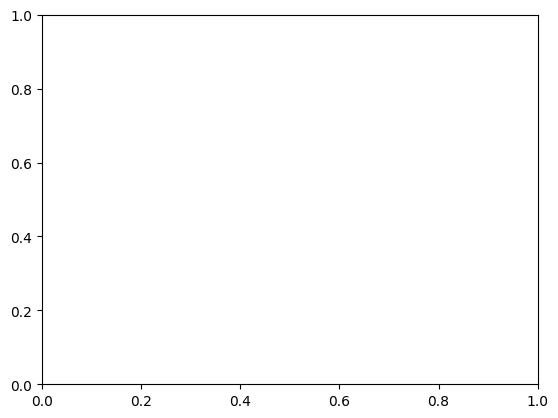

In [ ]:
plt.plot(s)